## Mean-Variance Portfolio Optimisation
***
Data Provided by Code Academy

### Introduction
The fundamental goal of portfolio theory is to allocate your investments between multiple assets optimally. A Markowitz mean-variance optimization (MVO) is an approach to choosing how to allocate money between multiple assets by considering the risk-return trade-off of asset combinations.

The approach considers the expected returns and covariance for all assets. It returns a set of portfolios where:
- The expected return is greater than any other with the same or lesser risk
- The risk is less than any other with the same expected return

For example, a Markowitz optimization could recommend how to distribute your money between Nike, Under Armour, and Skechers. In this example, to make the recommendation, we will consider historical data from the last 22 quarters to split $10,000 between each company. To minimize the risk of your portfolio, you should invest the following amounts in each company:
- Nike: $8,157
- Under Armour: $1,667
- Skechers: $176

You should invest the following amounts to maximize return:
- Nike: $0
- Under Armour: $0
- Skechers: $10,000

In [18]:
# Importing our modules and data
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers

stock_data = pd.read_csv('Stock_Data_CA.csv')
stock_data.head()

,Date,Delta,Jet Blue,Chevron,Exxon,Adobe,Honeywell
0,31/12/2007,14.64,5.94,94.37,94.39,42.58,60.89
1,31/03/2008,8.65,5.45,84.95,85.69,35.69,55.72
2,30/06/2008,5.42,3.58,98.30,86.81,39.63,49.26
3,30/09/2008,7.50,4.70,78.85,75.62,36.72,41.55
4,31/12/2008,10.97,6.80,72.90,78.42,20.85,32.61


In [19]:
# Selecting the Prices Columns
prices_cols = list(stock_data.columns[1:])
print(prices_cols)

['Delta', 'Jet Blue', 'Chevron', 'Exxon', 'Adobe', 'Honeywell']


In [20]:
# Calculating quarterly returns
quarterly_returns = stock_data[prices_cols].pct_change()
quarterly_returns.head()

,Delta,Jet Blue,Chevron,Exxon,Adobe,Honeywell
0,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.409153,-0.082492,-0.099820,-0.092171,-0.161813,-0.084907
2,-0.373410,-0.343119,0.157151,0.013070,0.110395,-0.115937
3,0.383764,0.312849,-0.197864,-0.128902,-0.073429,-0.156516
4,0.462667,0.446809,-0.075460,0.037027,-0.432190,-0.215162


In [21]:
# Calculating expected returns
expected_returns_avg = quarterly_returns.mean()
print('Quarterly Returns')
print(expected_returns_avg)

Quarterly Returns
Delta        0.062093
Jet Blue     0.052361
Chevron      0.010323
Exxon       -0.002444
Adobe        0.053780
Honeywell    0.028439
dtype: float64


### Expected Return II
To estimate the return and volatility of a portfolio with multiple assets, we need first to calculate the amount that we invest in each asset.

The _weight_ of an asset is the fraction of the money invested in the asset (the numerator of the fraction below), divided by the total amount of money in the portfolio (the denominator of the fraction below):

$$
w_n = \frac{c_n}{total}
$$

In the example below we have  $10,000 dollars to invest in three companies. We choose to invest $3,000 in Nike, $2,000 in Under Armour, and $5,000 in Skechers. Let's calculate the weighting for each group


In [22]:
# Calculating Weights
weight_nike = 3000 / 10000
weight_ua = 2000 / 10000
weight_skechers = 5000 / 10000

print(f'The weight invested in Nike is {weight_nike}')
print(f'The weight invested in Under Armour is {weight_ua}')
print(f'The weight invested in Skechers is {weight_skechers}')


The weight invested in Nike is 0.3
The weight invested in Under Armour is 0.2
The weight invested in Skechers is 0.5


### Expected Return III

We’re interested in the return of a portfolio with multiple assets. To calculate the expected return of a portfolio, we must find the _weighted sum of the return for each individual asset_:

$$
ER = w_1R_1 + w_2R_2 + w_3R_3 + ... + w_nR_n
$$

where:

$w_n$ is the weighting

$R_n$ is the return

In [23]:
# Calculating the expected returns
weights = [weight_nike, weight_ua, weight_skechers]
returns = [0.014, 0.008, 0.07]

expected_returns = sum([i * j for i,j in zip(weights, returns)])
print('The expected return is equal to {:.2f}%'.format(expected_returns))

The expected return is equal to 0.04%


### Inputs: Covariance Matrix I

The measure of an asset’s unpredictability is called its _risk_. We can estimate the risk of an asset by calculating its variance. If an asset’s return is very unpredictable, then its variance will be large and the investment considered risky. If an asset’s variance is small, the asset’s returns are predictable and the asset is not as risky.

When we quantify the risk of a portfolio, in addition to the variance of each asset, we must calculate the covariance between each asset and every other asset. If two assets have a positive covariance, then they respond similarly to market forces. Assets with a negative covariance will not. For example

- Oil prices affect car sales, which will impact automobile company returns (Ford, Honda, Toyota, General Motors)
- Increasing farm subsidies make crop production cheaper, which will increase agriculture returns. Agriculture companies, like Tyson, Monsanto, and Cargill will likely all increase in value (positive covariance).
- Tariffs on electronics may affect cell phone sales, which will decrease returns for hardware manufacturing companies, like Huawei, Apple, and Google (positive covariance).

Assets can have a positive covariance, negative covariance, or no covariance:

- **Positive covariance** — when one asset increases in value, the other usually increases in value. The covariance value will be greater than 0.
- **Negative covariance** — when one asset increases in value, the other usually decreases in value. The covariance value will be less than 0.
- **Uncorrelated assets** — when there is no quantifiable pattern to the response of two assets. The covariance value is equal to 0.

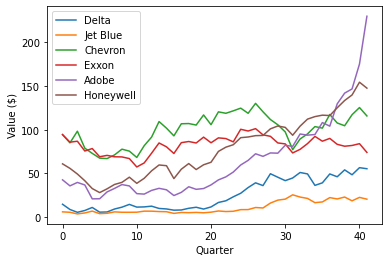

In [24]:
# Plotting the data to take an intial look at any correlation

stock_data.plot()
plt.xlabel('Quarter')
plt.ylabel('Value ($)')
plt.show()

### Inputs: Covariance Matrix II
To make computations more manageable, we store variances and covariances of assets in a covariance matrix. A covariance matrix is symmetric, with the variance of each asset on the diagonal. For example, the covariance matrix of a three-asset portfolio would look like:

\begin{bmatrix}
\sigma_{1} & \sigma_{1,2} & \sigma_{1,3} \\
\sigma_{1,2} & \sigma_{2} & \sigma_{2,3} \\
\sigma_{1,3} & \sigma_{2,3} & \sigma_{3}
\end{bmatrix}

In [25]:
# Calculating the covariance of the matrix
returns_cov = quarterly_returns.cov()
print(returns_cov)

              Delta  Jet Blue   Chevron     Exxon     Adobe  Honeywell
Delta      0.057825  0.037921 -0.000407  0.002053  0.004228   0.008055
Jet Blue   0.037921  0.044951 -0.001776  0.002404 -0.001467   0.005532
Chevron   -0.000407 -0.001776  0.010988  0.007023  0.004638   0.007022
Exxon      0.002053  0.002404  0.007023  0.007233  0.003111   0.006190
Adobe      0.004228 -0.001467  0.004638  0.003111  0.022535   0.011297
Honeywell  0.008055  0.005532  0.007022  0.006190  0.011297   0.013206


### Efficient Frontier I
Now we’re ready to visualize the mean-variance tradeoff for a collection of random portfolios. In this exercise, we provide you with a function, called return_portfolios() that accepts the expected returns and covariance matrix for a collection of assets. The function returns a DataFrame with 5,000 portfolios of random asset weights.

In [26]:
# Defining our return_portfolios() function
def return_portfolios(expected_returns, cov_matrix):
  np.random.seed(1)
  port_returns = []
  port_volatility = []
  stock_weights = []
    
  selected = (expected_returns.axes)[0]
    
  num_assets = len(selected) 
  num_portfolios = 5000
    
  for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
  for counter,symbol in enumerate(selected):
    portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
  df = pd.DataFrame(portfolio)
    
  column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
  df = df[column_order]
   
  return df

In [27]:
# Using our function
expected_returns = quarterly_returns.mean()
cov_quarterly = quarterly_returns.cov()

random_portfolios = return_portfolios(expected_returns, cov_quarterly)

print(random_portfolios.head().round(4))

   Returns  Volatility  Delta Weight  Jet Blue Weight  Chevron Weight  \
0   0.0437      0.1477        0.2484           0.4290          0.0001   
1   0.0290      0.0893        0.0724           0.1344          0.1543   
2   0.0347      0.1054        0.0742           0.3186          0.0099   
3   0.0198      0.0835        0.0451           0.0636          0.2572   
4   0.0463      0.1432        0.2978           0.3040          0.0289   

   Exxon Weight  Adobe Weight  Honeywell Weight  
0        0.1801        0.0874            0.0550  
1        0.2095        0.1630            0.2664  
2        0.2432        0.1514            0.2027  
3        0.3110        0.1007            0.2224  
4        0.0133        0.0577            0.2984  


### Efficient Frontier II
When we have a set of portfolios, we typically plot them on a two-dimensional scatter plot, with standard deviation on the x-axis and expected return on the y-axis.

```return_portfolios()``` returns a DataFrame with the expected return and volatility for each portfolio. We can plot these portfolios below

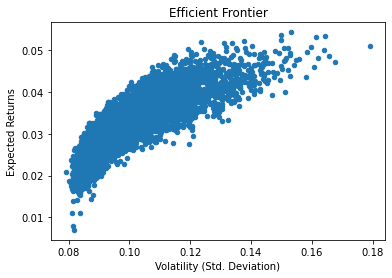

In [28]:
random_portfolios.plot.scatter(x='Volatility', y='Returns')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### Efficient Frontier III

In this exercise, we will create a function called optimal_portfolio(), to find mean-variance optimized portfolios.

The optimal_portfolio() function has one parameter:

- returns — the returns for all assets over a specified timeframe

The optimal_portfolio() function returns:

- weights — the weights for each asset in the portfolio
- returns — the expected returns of each portfolio
- risks — the risk of each portfolio, measured as standard deviation

In [31]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

     pcost       dcost       gap    pres   dres
 0: -3.6910e-02 -1.0606e+00  1e+00  3e-17  3e+00
 1: -3.7860e-02 -7.0546e-02  3e-02  7e-17  9e-02
 2: -5.6522e-02 -6.1228e-02  5e-03  2e-16  3e-17
 3: -5.8910e-02 -5.9232e-02  3e-04  1e-16  2e-17
 4: -5.9195e-02 -5.9202e-02  7e-06  1e-16  2e-17
 5: -5.9202e-02 -5.9202e-02  7e-08  2e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6835e-02 -1.0604e+00  1e+00  1e-16  3e+00
 1: -3.7780e-02 -7.0358e-02  3e-02  1e-16  9e-02
 2: -5.6232e-02 -6.0905e-02  5e-03  1e-16  1e-17
 3: -5.8543e-02 -5.8888e-02  3e-04  1e-16  3e-17
 4: -5.8838e-02 -5.8849e-02  1e-05  1e-16  2e-17
 5: -5.8849e-02 -5.8849e-02  1e-07  1e-17  2e-17
 6: -5.8849e-02 -5.8849e-02  1e-09  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6751e-02 -1.0602e+00  1e+00  3e-17  3e+00
 1: -3.7691e-02 -7.0148e-02  3e-02  9e-17  9e-02
 2: -5.5918e-02 -6.0547e-02  5e-03  2e-16  2e-17
 3: -5.8147e-02 -5.8507e

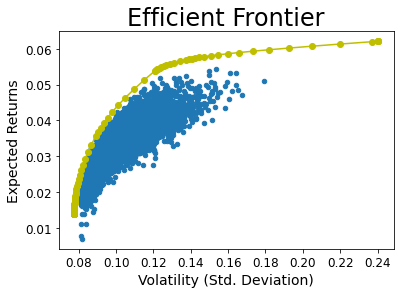

In [32]:

weights, returns, risks = optimal_portfolio(quarterly_returns[1:])

random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
try:
	plt.plot(risks, returns, 'y-o')
except:
  pass
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()